This is an example notebook to demonstrate the prediction of temperature time-series data using the generalized Langevin equation (GLE) on the example of a loaded Berlin weather trajectory.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from mempred import *

import datetime as dt

from wwo_hist import retrieve_hist_data

%matplotlib inline

## Loading weather data (here with OpenWeatherMap)

In [2]:
#frequency in hours!
#add your api key from OpenWeatherMap
#be careful! you only have 500 free calls each day!

#the DataFrame will be saved in the same folder

#key = 'f51f39fe055c46e09c8123240201002'
#data = load_temp("berlin", key = key, start_date = "10-FEB-2009", end_date = "07-MAR-2020", frequency = 24)

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-02-10,5,-1,0.0,4.9,1,1,89,07:42 PM,08:42 AM,...,-2,26,87,91,1.1,991,5,9,162,16
1,2009-02-11,3,0,0.2,4.9,1,1,82,09:07 PM,08:56 AM,...,-5,36,99,92,1.1,1001,3,8,298,23
2,2009-02-12,0,-3,0.0,4.9,1,1,74,10:29 PM,09:09 AM,...,-6,24,89,89,0.0,1012,0,10,293,15
3,2009-02-13,1,-4,0.0,9.9,2,2,67,11:49 PM,09:22 AM,...,-5,14,21,88,0.0,1016,1,9,266,10
4,2009-02-14,0,-5,0.2,6.6,1,1,59,No moonrise,09:36 AM,...,-7,20,65,93,0.2,1021,0,6,317,13


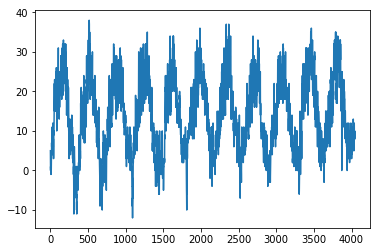

In [3]:
data = pd.read_csv('berlin.csv')
data.head()
data['maxtempC'].plot()

data.head()

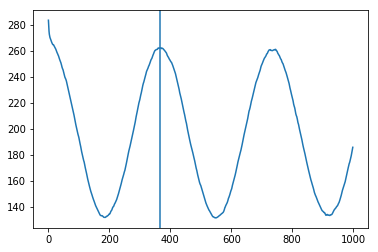

In [4]:
plt.plot(correlation(data["maxtempC"])[:1000])
plt.axvline(x=365)

## Memory Kernel Extraction (with fit)

fitted memory time: 9.46 time units
fitted osc. time: 164.05 time units
plotting extracted memory kernel...


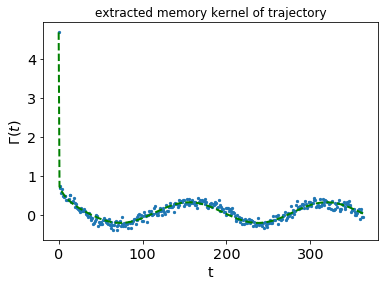

plotting running integral of kernel...


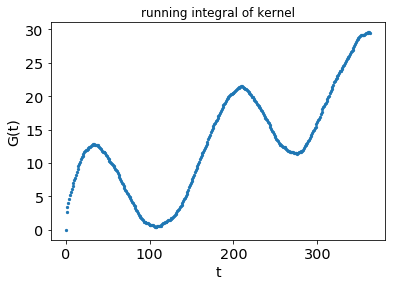

In [5]:
#data.index = pd.to_numeric(data.index, errors='coerce').fillna(0).astype(int)
#data["maxtempC"] = pd.to_numeric(data["maxtempC"], errors='coerce').fillna(0).astype(int)

cut = len(data)-300
n_steps = 100
trunc = 365
p0 = (1,1,1,167,0,0)
predict=GLEPredictionMETEO(bins=32,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = True)
kernel = predict.extractKernel([data["maxtempC"].values], fit_kernel = True, fit_start = 1, plot_kernel = True,p0 = p0)

## Performing prediction by extracting memory kernel and simulate GLE

In [ ]:
#important to convert all strings to floats!! In future version, this will already be in loaddata.py

#data.index = pd.to_numeric(data.index, errors='coerce').fillna(0).astype(int)
#data["maxtempC"] = pd.to_numeric(data["maxtempC"], errors='coerce').fillna(0).astype(int)

cut = len(data)-500
n_steps = 150
trunc = 167
predict=GLEPredictionMETEO(bins=32,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = True)
kernel = predict.extractKernel([data["maxtempC"].values])

GLE=predict.predictGLE([data["maxtempC"].values], n_steps=n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 10)

plotting prediction...


In [ ]:
fr_trj = GLE[-1]
plt.plot(fr_trj[cut-10:],label='predicted random force (one realisation)')
plt.plot(fr_trj[cut-10:cut],label='historical random force')
plt.legend(loc='best',frameon=False)

### Seasonality Mode (The data is fitted with oscillation before Kernel extraction)
Since we now that this oscillation has to be included in the memory kernel, we split the memory kernel in oscillation and the residual. We then predict the residual part and add it to the extrapolated oscillation.

plotting extracted memory kernel...


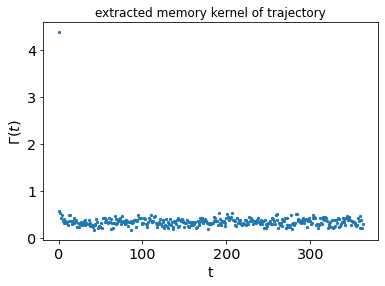

plotting running integral of kernel...


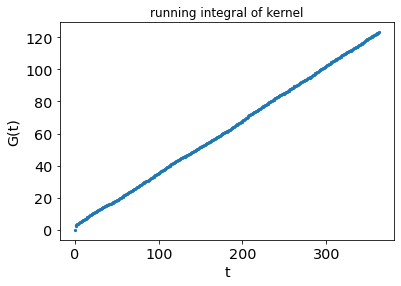

plotting prediction...


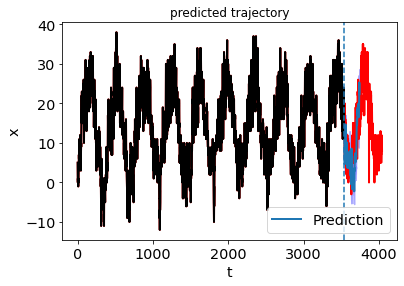

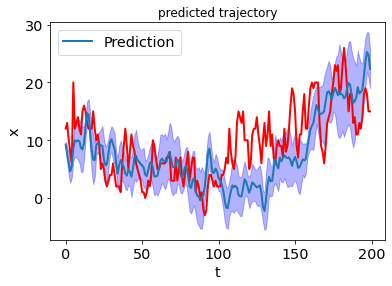

In [9]:
cut = len(data)-500
n_steps = 200
trunc = 365
p0 = (1,1,1,167,0,0)
predict=GLEPredictionMETEO(bins=32,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = True,seas_mode = True)
kernel = predict.extractKernel([data["maxtempC"].values],plot_kernel = True,p0 = p0)

GLE=predict.predictGLE([data["maxtempC"].values], n_steps=n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 10)

plotting prediction...


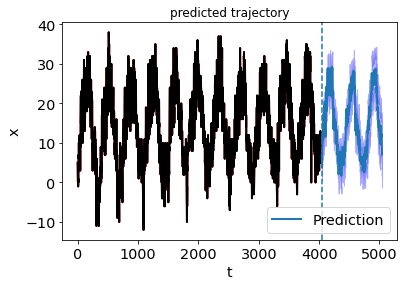

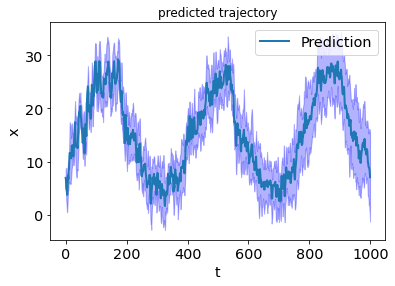

In [10]:
cut = len(data)
n_steps = 1000
trunc = 365
p0 = (1,1,1,167,0,0)
predict=GLEPredictionMETEO(bins=32,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = True,seas_mode = True)
kernel = predict.extractKernel([data["maxtempC"].values],plot_kernel = False,p0 = p0)

GLE=predict.predictGLE([data["maxtempC"].values], n_steps=n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 10)

### Combine mempred with Prophet

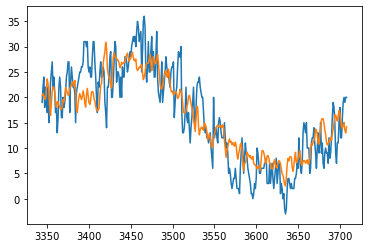

In [24]:
from fbprophet import Prophet 
#install via conda install fbprophet -c conda-forge or pip install fbprophet (pystan has to be installed first)

cut = len(data)-700
n_steps = 365
trunc = 400

m = Prophet(daily_seasonality = True, weekly_seasonality = True, yearly_seasonality = True)
#df = pd.DataFrame(trj['maxtempC'],trj.index)
df = pd.concat([data["date_time"][:cut], data["maxtempC"][:cut]], axis=1, keys=['ds', 'y'])
m.fit(df)

future = m.make_future_dataframe(periods=n_steps)
#future.tail()
predProph = m.predict(future)
data_res=  data["maxtempC"][:cut] - predProph['yhat'][:cut]


predict=GLEPredictionMETEO(bins=32,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = False)
kernel = predict.extractKernel([data_res.values])

GLE=predict.predictGLE([data_res.values], n_steps=n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 10)

prediction = GLE[2] + predProph['yhat'][cut:cut+n_steps]

plt.plot(data["maxtempC"][cut:cut+n_steps])
plt.plot(prediction)

## Also here, a hyper parameter optimization using mpGridSearch can be performed!

optimal alpha : 1
optimal trunc : 170
optimal conditional time : None


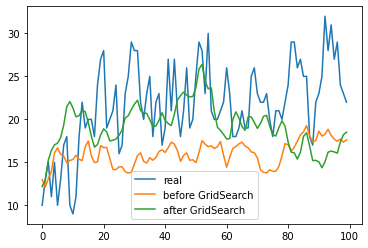

In [7]:
truncs = np.arange(150,200,5)
alphas = np.arange(1,10,2)
ts = [None]
n_steps = 100

cut = 3000


best_error, pred_GLE_best, best_trunc, best_alpha,best_th = mp_grid_search(data, value = 'maxtempC', cut = cut, n_steps = n_steps, truncs = truncs, alphas = alphas,ts = ts)

mem = GLEPredictionMETEO(cut = cut, dt = 1, trunc = best_trunc, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([data["maxtempC"].values])
pred_GLE_best=mem.predictGLE([data["maxtempC"].values], n_steps = n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = best_alpha,cond_noise = best_th)

mem = GLEPredictionMETEO(cut = cut, dt = 1, trunc = 100, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([data["maxtempC"].values])
predGLE_default=mem.predictGLE([data["maxtempC"].values], n_steps = n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 1)

plt.plot(data["maxtempC"][cut:cut+n_steps].values, label = 'real')
plt.plot(predGLE_default[2], label = 'before GridSearch')
plt.plot(pred_GLE_best[2], label = 'after GridSearch')
plt.legend(loc = 'best')